In [3]:
!pip install bed_reader

In [4]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
from bed_reader import open_bed, sample_file

In [5]:
def simulator(X, sigma):
    '''
    Simulate phenotype y from X and sigmas
    '''
    N = X.shape[0]
    M = X.shape[1]
    y = np.zeros((N,1))
    sigma_epsilon=1 - sigma # environmental effect sizes
    betas = np.random.randn(M,1)*np.sqrt(sigma) # additive SNP effect sizes
    y += X@betas/np.sqrt(M)
    #print(f'sigma_epislon={sigma_epsilon}')
    y += np.random.randn(N,1)*np.sqrt(sigma_epsilon) # add the effect sizes
    return y, betas

def solve_linear_equation(X, y):
    '''
    Solve least square
    '''
    sigma = np.linalg.lstsq(X, y, rcond=None)[0]
    return sigma


def solve_linear_qr(X, y):
    '''
    Solve least square using QR decomposition
    '''
    Q, R = scipy.linalg.qr(X)
    sigma = scipy.linalg.solve_triangular(R, np.dot(Q.T, y))
    return sigma

def RHE(X,y,num_random_vect=10,seed=1,verbose=False):
    '''
    RHE estimation
    '''
    np.random.seed(seed)
    N = X.shape[0]
    M = X.shape[1]
    T = np.zeros((2,2))
    q = np.zeros((2,1))

    Xi = X.copy()/np.sqrt(M)
    for _ in range(num_random_vect):
        # Generate random vector to estimate trace
        rand_vector = np.random.randn(N,1)
        T[0,0] += rand_vector.T@Xi@Xi.T@Xi@Xi.T@rand_vector/num_random_vect

    T[1,0] = np.trace(Xi@Xi.T)
    T[0,1] = T[1,0]
    T[1,1] = N

    q[0] = y.T@Xi@Xi.T@y
    q[1] = y.T@y

    if verbose:
        print(T)
    sigma_est = solve_linear_equation(T,q)
    return sigma_est


def HE (X, y, verbose = False):
    '''
    HE estimation (without using random vectors)
    '''
    N = X.shape[0]
    M = X.shape[1]
    T = np.zeros((2,2))
    q = np.zeros((2,1))

    Xi = X.copy()/np.sqrt(M)
    T[0,0] = np.trace(Xi@Xi.T@Xi@Xi.T)
    T[1,0] = np.trace(Xi@Xi.T)
    T[0,1] = T[1,0]
    T[1,1] = N

    q[0] = y.T@Xi@Xi.T@y
    q[1] = y.T@y

    if verbose:
        print(T)

    sigma_est = solve_linear_equation(T,q)
    return sigma_est

## In the cell below, we simulate the genotype matrix by taking random samples of the MAF for each SNP from a uniform distribution. Then for each individual (based on the MAF of that SNP), run a Bernoulli trial to get the genotype value at that location (i.e., whether the individual has the SNP or not; either 0,1 or 2)
I'll also share the genotype matrices for you to benchmark RHE and the python version (here), but this a very simple simulation. For instance, here we don't consider the LD structure here at all.

In [6]:
M=100 # M = 500000
N=10000  # N=300000
target_index=1
sigmas_list=[0.3]
# t0 = time()
for i in range(1):
    np.random.seed(i)
    sigmas=sigmas_list[i]

    MAFs = np.random.uniform(0.01,0.5,M)

    P_matrix = np.tile(MAFs, (N, 1))

    # num of success in 2 trials
    X = np.random.binomial(2, P_matrix) # X here is the un-standardized, raw genotype matrix (entries are 0, 1, or 2)

    X = StandardScaler().fit_transform(X) # standardize X

    y, beta_list = simulator(X, sigmas) # generate phenotype with some beta values

    print(f'Actual sigmas are: {sigmas}')
    sigma_est=RHE(X,y,num_random_vect=10,seed=42) # run py-RHE
    sigma_est2=HE(X, y)

    print ('RHE estimated sigmas are:',*sigma_est, '\nHE estimated sigmas are:', *sigma_est2)

Actual sigmas are: 0.3
RHE estimated sigmas are: [0.27646048] [0.71014217] 
HE estimated sigmas are: [0.28039846] [0.7062042]


## And here's an (almost) identical code but instead of simulating genotype, it reads in the genotype file (.bed) using the bed-reader. One major difference is, in real genotype, there is often missingness, which needs to be imputed.
### Here's one way of imputing: simply replace the missing values by the average of non-missing entries for that SNP. This is different than what's done in the RHE code.


In [7]:
'''
impute the genotype matrix for any missingness by using the average of other samples
this function also standardizes it
'''
def impute_geno(X):
    N = X.shape[0]
    M = X.shape[1]
    X_imp = X.copy()
    for m in range(M):
        cnt = 0
        csum = 0
        for n in range(N):
            if not np.isnan(X[n, m]):
                cnt += 1
                csum += X[n,m]
        csum /= cnt
        X_imp[:,m] = np.nan_to_num(X_imp[:,m], nan=csum*0.5)
    X_imp = (X_imp-np.mean(X_imp, axis=0))/np.std(X_imp, axis=0)
    return X_imp

In [56]:
geno_path="/Users/nijiayi/RHE_project/simulated_geno/simulated_geno_1.bed"
bed = open_bed(geno_path)
X = bed.read()
print(X)
print(X.shape)

[[0. 0. 0. ... 2. 1. 1.]
 [0. 1. 2. ... 2. 0. 0.]
 [0. 0. 1. ... 0. 1. 2.]
 ...
 [1. 2. 0. ... 1. 2. 1.]
 [1. 1. 0. ... 2. 0. 1.]
 [1. 0. 1. ... 1. 1. 1.]]
(3949, 2808)


In [43]:
X_imp = impute_geno(X)
print(X_imp)

[[-0.7989463  -0.21210708 -0.38583896 ...  0.78404874 -0.5160357
  -0.5581683 ]
 [-0.7989463  -0.21210708 -0.38583896 ... -0.813857   -0.5160357
  -0.5581683 ]
 [-0.7989463  -0.21210708 -0.38583896 ... -0.813857   -0.5160357
  -0.5581683 ]
 ...
 [-0.7989463  -0.21210708 -0.38583896 ... -0.813857   -0.5160357
  -0.5581683 ]
 [-0.7989463  -0.21210708 -0.38583896 ...  2.3819544  -0.5160357
   1.4910861 ]
 [-0.7989463  -0.21210708 -0.38583896 ... -0.813857    1.6690814
   1.4910861 ]]


In [10]:
sigma = 0.2
y, beta_list = simulator(X_imp, sigma) # generate phenotype with some beta values

print(f'Actual sigmas are: {sigma}')
sigma_est=RHE(X_imp,y,num_random_vect=10,seed=42) # run py-RHE
sigma_est2=HE(X_imp, y) # run exact-HE

print ('RHE estimated sigmas are:',*sigma_est, '\nHE estimated sigmas are:', *sigma_est2)

Actual sigmas are: 0.2
RHE estimated sigmas are: [0.16427576] [0.83198898] 
HE estimated sigmas are: [0.16982971] [0.82643503]


## TODO: In the "geno" directory, you will find several genotype (.bed) files with multiple combinations of N (samples) and M (snps). As discussed in our meeting:

## 1. Benchmark the python version of RHE & HE and the original, C++ version on those genotypes files and plot the run time (y-axis) against NxM (x-axis), and interpolate to large samples (UKBB) of 300k individuals x 454k SNPs.

## 2. Repeat the same, but using the simulated genotypes
For simulated phenotypes, to run it on the C++ RHE, you'd have to port the matrix into PLINK bed. Read https://zzz.bwh.harvard.edu/plink/binary.shtml for how the encoding works. You might also want to take a look at this documentation for packages that does it: https://rdrr.io/cran/genio/man/write_bed.html

In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d

In [60]:
rhe_runtimes = []
he_runtimes = []
nxm_values = []

directory = "/Users/nijiayi/RHE_project/geno/"

genotype_files = glob.glob(directory + "*.bed")

Using Actual Genotypes:

In [14]:
for geno_path in genotype_files:
    bed = open_bed(geno_path)
    X = bed.read()
    nxm_values.append(X.shape[0] * X.shape[1])
    X_imp = impute_geno(X)


    sigma = 0.2
    y, beta_list = simulator(X_imp, sigma) # Generate phenotype with some beta values

    # runtime for RHE
    start_time = time.time()
    sigma_est = RHE(X_imp, y, num_random_vect=10, seed=42)
    end_time = time.time()
    rhe_runtime = end_time - start_time
    rhe_runtimes.append(rhe_runtime)

    # runtime for HE
    start_time = time.time()
    sigma_est2 = HE(X_imp, y)
    end_time = time.time()
    he_runtime = end_time - start_time
    he_runtimes.append(he_runtime)

In [15]:
data = list(zip(nxm_values, rhe_runtimes, he_runtimes))
sorted_data = sorted(data, key=lambda x: x[0])
sorted_nxm_values, sorted_rhe_runtimes, sorted_he_runtimes = zip(*sorted_data)

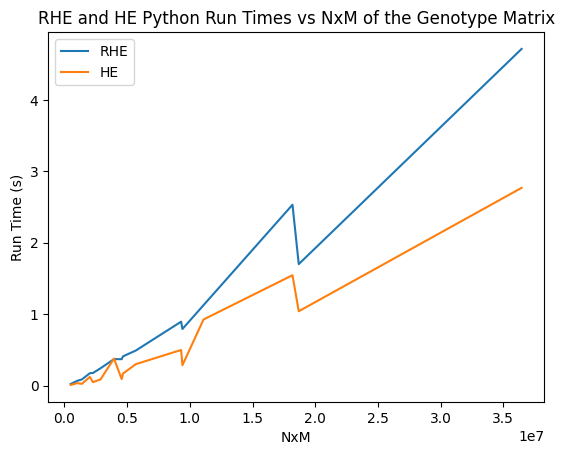

In [16]:
plt.plot(sorted_nxm_values, sorted_rhe_runtimes, label='RHE')
plt.plot(sorted_nxm_values, sorted_he_runtimes, label='HE')
plt.xlabel('NxM')
plt.ylabel('Run Time (s)')
plt.title('RHE and HE Python Run Times vs NxM of the Genotype Matrix')
plt.legend()
plt.show()

In [17]:
# interpolate
ukbb_N = 300000
ukbb_M = 454000

rhe_interp_func = interp1d(sorted_nxm_values, sorted_rhe_runtimes, fill_value='extrapolate')
he_interp_func = interp1d(sorted_nxm_values, sorted_he_runtimes, fill_value='extrapolate')

rhe_interpolated = rhe_interp_func(ukbb_N * ukbb_M )
he_interpolated = he_interp_func(ukbb_N * ukbb_M )

print(f"Interpolated RHE runtime with actual genotype file: {rhe_interpolated} seconds")
print(f"Interpolated HE runtime with actual genotype file: {he_interpolated} seconds")

Interpolated RHE runtime with actual genotype file: 23066.77020107829 seconds
Interpolated HE runtime with actual genotype file: 13230.173088741876 seconds


Using Simulated Genotypes:



In [47]:
nxm_values_tuples_sim = []
nxm_values_sim = []
rhe_runtimes_sim = []
he_runtimes_sim = []
geno_matrices = []
pheno_matrices = []


for geno_path in genotype_files:
    bed = open_bed(geno_path)
    X = bed.read()

    N = X.shape[0]
    M = X.shape[1]

    nxm_values_tuples_sim.append((N, M))
    nxm_values_sim.append(N*M)

    np.random.seed(0)

    sigma = 0.3

    MAFs = np.random.uniform(0.01, 0.5, M)
    P_matrix = np.tile(MAFs, (N, 1))
    X = np.random.binomial(2, P_matrix)

    geno_matrices.append(X)

    X = StandardScaler().fit_transform(X) # standardize X


    y, beta_list = simulator(X, sigma)
    pheno_matrices.append(y)


    # runtime for RHE
    start_time = time.time()
    sigma_est = RHE(X, y, num_random_vect=10, seed=42)
    end_time = time.time()
    rhe_runtime_sim = end_time - start_time
    rhe_runtimes_sim.append(rhe_runtime_sim)

    # runtime for HE
    start_time = time.time()
    sigma_est2 = HE(X, y)
    end_time = time.time()
    he_runtime_sim = end_time - start_time
    he_runtimes_sim.append(he_runtime_sim)

In [35]:
print(nxm_values_tuples_sim)

data = list(zip(nxm_values_sim, rhe_runtimes_sim, he_runtimes_sim))
sorted_data = sorted(data, key=lambda x: x[0])
sorted_nxm_values_sim, sorted_rhe_runtimes_sim, sorted_he_runtimes_sim = zip(*sorted_data)

print(sorted_nxm_values_sim)
print(sorted_rhe_runtimes_sim)
print(sorted_he_runtimes_sim)

[(3949, 2808), (496, 4577), (2030, 4583), (1022, 996), (496, 2803), (2030, 2803), (3949, 4605), (2030, 9204), (1022, 4570), (496, 9199), (1022, 9205), (3949, 1000), (3949, 9232), (2030, 999), (1022, 2811), (496, 1001)]
(496496, 1017912, 1390288, 2027970, 2270192, 2872842, 3949000, 4562704, 4670540, 5690090, 9303490, 9407510, 11088792, 18185145, 18684120, 36457168)
(0.006304025650024414, 0.03277325630187988, 0.02107071876525879, 0.058923959732055664, 0.04945993423461914, 0.05781197547912598, 0.17069697380065918, 0.07315587997436523, 0.11650514602661133, 0.5265328884124756, 0.3209240436553955, 0.2663581371307373, 0.5175437927246094, 0.7433681488037109, 0.48981595039367676, 1.5305511951446533)
(0.015607118606567383, 0.07822322845458984, 0.12635493278503418, 0.19739222526550293, 0.10067892074584961, 0.148468017578125, 0.6989340782165527, 0.21492409706115723, 0.26788997650146484, 0.8551311492919922, 1.0573740005493164, 0.43714404106140137, 1.934736967086792, 2.7314722537994385, 1.6056330204

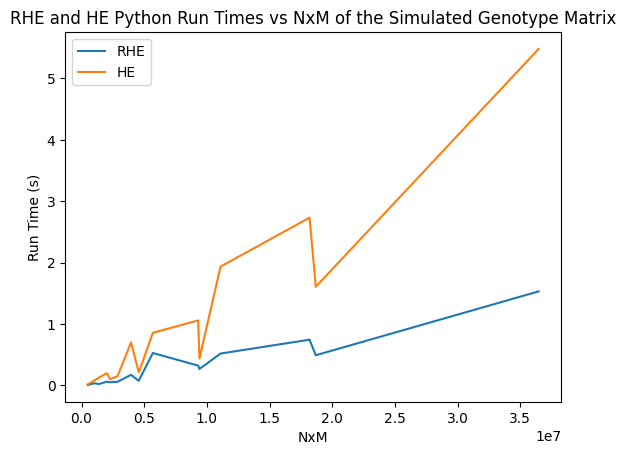

In [36]:
plt.plot(sorted_nxm_values_sim, sorted_rhe_runtimes_sim, label='RHE')
plt.plot(sorted_nxm_values_sim, sorted_he_runtimes_sim, label='HE')
plt.xlabel('NxM')
plt.ylabel('Run Time (s)')
plt.title('RHE and HE Python Run Times vs NxM of the Simulated Genotype Matrix')
plt.legend()
plt.show()

In [37]:
ukbb_N = 300000
ukbb_M = 454000

rhe_interp_func = interp1d(sorted_nxm_values_sim, sorted_rhe_runtimes_sim, fill_value='extrapolate')
he_interp_func = interp1d(sorted_nxm_values_sim, sorted_he_runtimes_sim, fill_value='extrapolate')

rhe_interpolated = rhe_interp_func(ukbb_N * ukbb_M )
he_interpolated = he_interp_func(ukbb_N * ukbb_M )

print(f"Interpolated RHE runtime with simulated genotype file: {rhe_interpolated} seconds")
print(f"Interpolated HE runtime with simulated genotype file: {he_interpolated} seconds")

Interpolated RHE runtime with simulated genotype file: 7974.850494708581 seconds
Interpolated HE runtime with simulated genotype file: 29703.066640541638 seconds


In [55]:
from bed_reader import to_bed
for i, X in enumerate(geno_matrices):
    plink_bed_file = f"/Users/nijiayi/RHE_project/simulated_geno/simulated_geno_{i+1}.bed"
    
    to_bed(plink_bed_file, X)

In [59]:
for i, matrix in enumerate(pheno_matrices):
    file_name = f"/Users/nijiayi/RHE_project/simulated_geno/simulated_pheno_{i+1}.pheno"
    
    with open(file_name, 'w') as f:
        num_rows = matrix.shape[0]
        
        f.write("FID IID 1\n")
        
        for row_idx in range(num_rows):
            fid = row_idx + 1  
            iid = 1 
            value = str(matrix[row_idx]).strip('[]')
            f.write(f"{fid} {iid} {value}\n")

## C++ Implementation benchmark:

Using Actual Genotypes:

Using Simulated Genotypes:


## 3*.  If you are able to do these and get some sensible results, one extra task is to take a look at how RHE imputes & standardizes the genotype matrix, and see if you can implement it in python